# Predicting Market Movements with Google Trends Data
## Ming Fong and Alexander Yang
STAT 198 Fall 2020

3 December 2020

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from pytrends import dailydata
import requests
import collections
import os

from sklearn import linear_model
import statsmodels.api as sm

from backtesting import Backtest

from scipy.optimize import minimize


Loading BokehJS ...

## Introduction
In this project, we will attempt to create an event-driven strategy to trade index shares using alternative data from Google Trends. We will implement [this paper](https://www.nature.com/articles/srep01684.pdf) by Preis, Moat, and Stanley with modifications to their algorithm logic that will be detailed later.

## Data Collection and Processing
We sourced our alternative data from [Google Trends](https://trends.google.com/trends/?geo=US). Downloading data over a long time frame from the Google Trends website gives weekly datapoints with dates that are hard to control. To work around this, we used the third-party [Pytrends](https://pypi.org/project/pytrends/) API for Python. This API allows us to request daily data for any time interval.

For our financial data we used yfinance because of its ease of use. Because our trading intervals will be on the scale of days-weeks,  

### Data Problems
Because the API is third-party, you will get 429 errors (too many requests) after about 3 years of daily data. We created a script that downloads and saves Google search trend data and ran it in a Kaggle Docker Container to save time. The script output can be downloaded from the [Kaggle notebook](https://www.kaggle.com/evilpegasus/pytrends-test/output). The CSVs are spread across different versions.

Another problem is how the search volume values are computed by Google. Google samples a subset of its servers for the volume data. As a result, there are small variations between different requests with the same parameters. We determined that the difference was negligible to the overall trends, although this could be looked into more thoroughly.


In [2]:
x = os.walk("trends")
for word in x:
    tuplee = word
words = tuplee[2]

We get two time periods of index prices: 2010 - 2018 and 2019 -2020 for training and testing respectively.

Our index of choice is the NASDAQ Composite (NDAQ). We found this index to have the best performace using this strategy.

In [3]:
# Prepare the training data
start_year = 2010
start_month = 1
end_year = 2018
end_month = 12
index = "NDAQ"

training_index = yf.download(index, start = str(start_year)+"-"+str(start_month)+"-01", end = str(end_year)+"-"+str(end_month)+"-01")

[*********************100%***********************]  1 of 1 completed


In [4]:
# Prepare the testing data
start_year = 2019
start_month = 1
end_year = 2020
end_month = 11
index = "NDAQ"

testing_index = yf.download(index, start = str(start_year)+"-"+str(start_month)+"-01", end = str(end_year)+"-"+str(end_month)+"-01")

[*********************100%***********************]  1 of 1 completed


In [5]:
def getStats(key_word, start_year, start_month, end_year, end_month, index_data):
    #trend = pd.DataFrame(dailydata.get_daily_data(key_word, start_year, start_month, end_year, end_month, wait_time = 0)[key_word])
    trend = pd.read_csv("trends/"+key_word)
    key_word = key_word[:-4]
    trend['date'] = pd.to_datetime(trend['date'])
    trend = trend.set_index('date')
    trend["change"] = trend[key_word].pct_change()

    # join trend data with index data
    joined = trend.merge(index_data, left_on = trend.index, right_on = index_data.index)
    joined = joined.rename(columns = {"key_0": "Date"})

    # grab the adj close price difference for each day
    #joined['Diff'] = joined['Adj Close'].diff()
    joined = joined.set_index(joined['Date'])

    joined["change moving avg"] = joined["change"].rolling("14d", min_periods = 1).mean()
    joined = joined[joined.index.dayofweek == 1]
    
    return joined

In [6]:
# training data
training = {}

for word in words:
    if word[0] == ".": # extra thing in there
        continue
    training[word] = getStats(word, start_year, start_month, end_year, end_month, training_index)

In [7]:
# testing data
testing = {}

for word in words:
    if word[0] == ".": # extra thing in there
        continue
    testing[word] = getStats(word, start_year, start_month, end_year, end_month, testing_index)

# EDA
We can plot the Google Trends scaled data:

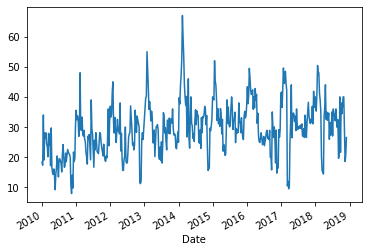

In [8]:
training["returns.csv"]["returns"].plot()

Our merged Google Trends and asset price DataFrame looks like this:

In [9]:
training["returns.csv"].head()

,Date,returns_unscaled,returns_monthly,isPartial,scale,returns,change,Open,High,Low,Close,Adj Close,Volume,change moving avg
Date,,,,,,,,,,,,,,
2010-01-05,2010-01-05,54,34.0,NaN,0.34,18.36,-0.100000,19.930000,20.320000,19.930000,20.299999,17.419601,1481700,-0.023684
2010-01-12,2010-01-12,51,34.0,NaN,0.34,17.34,0.133333,20.160000,20.299999,19.820000,19.930000,17.102102,1732800,0.027288
2010-01-19,2010-01-19,100,34.0,NaN,0.34,34.00,0.587302,20.160000,20.240000,20.040001,20.129999,17.273724,1052300,0.108292
2010-01-26,2010-01-26,56,34.0,NaN,0.34,19.04,-0.111111,18.150000,18.430000,18.100000,18.100000,15.531766,2569300,0.040744
2010-02-02,2010-02-02,85,33.0,NaN,0.33,28.05,-0.150000,18.459999,18.719999,18.400000,18.580000,15.943654,1849600,0.034571


We are primarily interested in the `returns` column, which gives the scaled search volume for the "returns" key word. The first four columns are used to calculate the scaled value. `change` is the difference between the current search volume and the last day's search volume. `change moving avg` calculates the 14-day moving average of the `change` column.

# Training

### We begin backtesting our model using the python [Backtesting.py library](https://kernc.github.io/backtesting.py/). 
### Our algorithm is as follows:
1. We have already calculated the change moving average. If that value is above some "high" threshold, then we buy at the current value. The intuition being that an increase in search volume on financially correlated keywords will lead to a positive impact on the market and a increased price in our index due to increased investor interest in the overall market. Conversely, if the change moving average is below some "low" threshold, we will sell at the current value.
2. Now, we need to define the "high" and "low" thresholds to execute our buy and sell trades. We optimize our backtest (on all words available) to find the best values for each word for our "high" and "low" parameters to optimize returns. 
3. We previously created an 80-20 train-test split by subsetting the first 8 years (2010-2018) as our training data and the next two years (2019-2020) as our testing data.
4. We run our testing model to find the optimized high and low thresholds.

In [10]:
# helper function to get data
def getMovingAvg(df):
    return pd.Series(df['change moving avg'])

In [11]:
from backtesting import Strategy
from backtesting.lib import crossover

class trainingStrat(Strategy):
    high = 0
    low = 0
    
    def init(self):
        self.change = self.I(getMovingAvg, self.data)
        high = self.high
        low = self.low

    def next(self):
        if self.change[-1] > self.high:
            self.position.close()
            #print("buying")
            self.buy()

        elif self.change[-1] < self.low:
            self.position.close()
            #print("selling")
            self.sell()
        else:
            self.position.close()

In [12]:
%%time

# optimizing each word and saving best high and low parameters
training_stats = {}
training_bts = {}

for word in training.keys():
    bt = Backtest(training[word], trainingStrat, cash=100_000_000, commission=0)
    stats = bt.optimize(low = list(np.asarray(range(-10, 21, 2))/100),
                        high = list(np.asarray(range(-10, 21, 2))/100), 
                        constraint = lambda param: param.low < param.high, 
                        maximize = 'Equity Final [$]',
                        return_optimization = True, method = 'skopt',
                        random_state = 88)
    #stats = bt.run()
    training_stats[word] = stats
    training_bts[word] = bt
    print("Finished "+word)
    
# training_stats

Finished arts.csv
Finished banking.csv
Finished bonds.csv
Finished buy.csv
Finished cash.csv
Finished chance.csv
Finished color.csv
Finished conflict.csv
Finished consumption.csv
Finished Coronavirus.csv
Finished covid.csv
Finished crash.csv
Finished credit.csv
Finished crisis.csv
Finished culture.csv
Finished debt.csv
Finished derivatives.csv
Finished dividend.csv
Finished dow jones.csv
Finished earnings.csv
Finished economics.csv
Finished economy.csv
Finished energy.csv
Finished fed.csv
Finished finance.csv
Finished financial markets.csv
Finished fine.csv
Finished food.csv
Finished freedom.csv
Finished gains.csv
Finished gold.csv
Finished growth.csv
Finished health.csv
Finished hedge.csv
Finished holiday.csv
Finished house.csv
Finished housing.csv
Finished inflation.csv
Finished invest.csv
Finished investment.csv
Finished leverage.csv
Finished loss.csv
Finished markets.csv
Finished metals.csv
Finished money.csv
Finished nasdaq.csv
Finished office.csv
Finished oil.csv
Finished ore.csv

In [13]:
# unpack the various values held within the optimized stats
returns = {}
sharpe = {}
win_rate = {}
avg_trade = {}
optimized_parameters = {}

for word in training.keys():
    returns[word] = training_stats[word][0][6]
    returns['BUY AND HOLD.csv'] = training_stats[word][0][7]
    sharpe[word] = training_stats[word][0][10]
    win_rate[word] = training_stats[word][0][18]
    avg_trade[word] = training_stats[word][0][21]
    optimized_parameters[word] = training_stats[word][1].x

### Returns (%) on testing data (2010 - 2018)

In [14]:
# get the training data returns for each word
optimized_words = [i[0] for i in sorted(returns.items(), key = lambda x: x[1], reverse = True)]
optimized_words_returns = sorted(returns.items(), key = lambda x: x[1], reverse = True)
returns_data = {'Key Word': [i[:-4] for i in optimized_words], 'Returns (%)': [i[1] for i in optimized_words_returns]}
training_returns = pd.DataFrame(returns_data)
training_returns = training_returns.set_index('Key Word')
training_returns.head(10)

,Returns (%)
Key Word,
quarantine,951.517187
debt,550.242564
rich,536.990730
chance,529.952433
gains,495.310881
ore,484.651674
derivatives,476.711631
revenue,472.299175
economics,470.038581


In [15]:
# get the returns of the BUY AND HOLD strategy to use as a benchmark
training_returns[training_returns.index == "BUY AND HOLD"]

,Returns (%)
Key Word,
BUY AND HOLD,340.689667


### Sharpe Ratio of training data (2010 - 2018)

In [16]:
optimized_words_sharpe = sorted(sharpe.items(), key = lambda x: x[1], reverse = True)
sharpe_data = {'Key Word': [i[0][:-4] for i in optimized_words_sharpe], 'Sharpe Ratio': [i[1] for i in optimized_words_sharpe]}
training_sharpe = pd.DataFrame(sharpe_data)
training_sharpe = training_sharpe.set_index('Key Word')
training_sharpe.dropna().head(10)

,Sharpe Ratio
Key Word,
chance,1.443421
economy,1.475908
quarantine,1.351861
economics,1.312248
returns,1.311301
markets,1.280422
metals,1.253405
housing,1.248457
rich,1.243125


Get the optimized low and high parameters for each word

In [17]:
optimized_words_parameters = {word:optimized_parameters[word] for word in optimized_parameters.keys()}
parameters_data = {'Key Word': [i[:-4] for i in optimized_words_parameters.keys()], 'Low Value': [i[1][0] for i in optimized_words_parameters.items()], 
                   'High Value': [i[1][1] for i in optimized_words_parameters.items()]}
parameters_df = pd.DataFrame(parameters_data)
parameters_df = parameters_df.set_index('Key Word')
parameters_df.head(10)

,Low Value,High Value
Key Word,,
arts,-0.055621,-0.036072
banking,0.011567,0.040936
bonds,-0.080450,0.004274
buy,-0.095382,-0.065161
cash,-0.041538,-0.015641
chance,-0.086325,-0.025300
color,-0.081577,-0.017520
conflict,-0.081577,-0.017520
consumption,-0.064459,-0.042230


# Testing

In [18]:
# all positive words here have sharpe ratio > 1,
"""
testing_words = ["invest.csv", "money.csv", "financial markets.csv", "bonds.csv", "stocks.csv", 
        "gains.csv", "derivatives.csv", "gold.csv", "dividend.csv", "rich.csv","revenue.csv", 
        "returns.csv", "nasdaq.csv", "dow jones.csv", "profit.csv", "economy.csv", "growth.csv",
       "investment.csv", "markets.csv", "banking.csv", "earnings.csv", "return.csv", "chance.csv", 
        "cash.csv"]
"""
testing_words = training.keys()

In [19]:
# slight modifications to testing dfs to let backtesting work
for word in testing_words:
    testing[word]['word'] = str(word)

In [20]:
from backtesting import Strategy
from backtesting.lib import crossover

def getMovingAvg(df):
    return pd.Series(df['change moving avg'])

def getOptimizedParameters(df):
    return optimized_parameters[df['word'][0]]

class testingStrat(Strategy):
    
    def init(self):
        self.change = self.I(getMovingAvg, self.data)
        self.optimized_parameters = getOptimizedParameters(self.data) # grabs the word from the df, had to add a new column with name
        #print(self.optimized_parameters)
        self.low = self.optimized_parameters[0]
        self.high = self.optimized_parameters[1]
        
    def next(self):
        if self.change[-1] > self.high:
            self.position.close()
            #print("buying")
            self.buy()

        elif self.change[-1] < self.low:
            self.position.close()
            #print("selling")
            self.sell()
        else:
            self.position.close()

In [21]:
# testing
testing_stats = {}
testing_bts = {}
for word in testing_words:
    bt = Backtest(testing[word], testingStrat, cash=100_000_000, commission=0)
    stats = bt.run() # we no longer optimize, but we run and grab the optimized parameters from training
    testing_stats[word] = stats
    testing_bts[word] = bt

In [22]:
# unpack the various values held within the stats
testing_returns = {}
testing_sharpe = {}
testing_win_rate = {}
testing_avg_trade = {}

for word in testing_words:
    testing_returns[word] = testing_stats[word][6]
    testing_returns["BUY AND HOLD.csv"] = testing_stats[word][7]
    testing_sharpe[word] = testing_stats[word][10]
    testing_win_rate[word] = testing_stats[word][18]
    testing_avg_trade[word] = testing_stats[word][21]

In [23]:
testing_optimized_words = [i[0] for i in sorted(testing_returns.items(), key = lambda x: x[1], reverse = True)]
testing_optimized_words_returns = sorted(testing_returns.items(), key = lambda x: x[1], reverse = True)

### Returns (%) of testing data (2019 - 2020)

In [24]:
testing_optimized_words_returns
returns_data = {'Key Word': [i[:-4] for i in testing_optimized_words], 'Returns (%)': [i[1] for i in testing_optimized_words_returns]}
testing_returns = pd.DataFrame(returns_data)
testing_returns = testing_returns.set_index('Key Word')
testing_returns.head(10)

,Returns (%)
Key Word,
transaction,84.961203
world,72.516561
travel,66.971049
vaccine,66.240552
housing,64.713117
revenue,57.986329
BUY AND HOLD,57.200296
gold,55.011033
ore,54.945630


### Sharpe Ratio of testing data (2019 - 2020)

In [25]:
testing_sharpe_words = sorted(testing_sharpe.items(), key = lambda x: x[1], reverse = True)
sharpe_data = {'Key Word': [i[0][:-4] for i in testing_sharpe_words], 'Sharpe Ratio': [i[1] for i in testing_sharpe_words]}
testing_sharpe = pd.DataFrame(sharpe_data)
testing_sharpe = testing_sharpe.set_index('Key Word')
testing_sharpe.head(10)

,Sharpe Ratio
Key Word,
transaction,1.375437
world,1.350403
travel,1.340903
housing,1.302250
revenue,1.242245
gold,1.219689
ore,1.203672
short selling,1.178927
consumption,1.178764


In [26]:
testing_bts[testing_optimized_words[0]].plot()

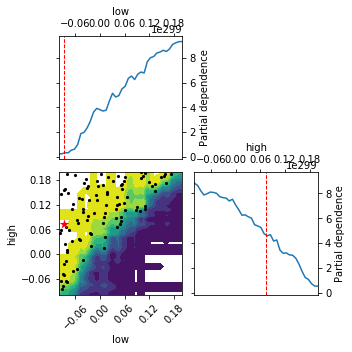

In [27]:
# visualize the optimization process for the "low" and "high" paramters

import skopt.plots 
x = skopt.plots.plot_objective(training_stats[testing_optimized_words[0]][1])

## Random Strategy Implementation and Comparison with Buy and Hold
We can compare our metrics with those of a strategy that randomly buys and sells and one that only buys and holds for the same periods.

The mean and standard deviation of the random strategy are calculated with `n = 1000` runs.

In [28]:
import random

# implement a benchmarking strategy that randomly buys and sells 
class randomStrat(Strategy):
    def init(self):
        self.change = self.I(getMovingAvg, self.data)
    def next(self):
        if random.choice([True, False]):
            self.position.close()
            self.buy()
        else:
            self.position.close()
            self.sell()

In [29]:
random_returns = []
best_word = testing_optimized_words[0]

for i in range(1000):
    bt = Backtest(testing[best_word], randomStrat, cash=100_000_000, commission=0) 
    random_stats = bt.run()
    random_returns.append(random_stats[6])
    if i == 0:
        random_rolling_mean_and_sd["sum"] = random_stats["_equity_curve"]['Equity']
        random_rolling_mean_and_sd["sumsq"] = random_stats["_equity_curve"]['Equity']**2
    else:
        random_rolling_mean_and_sd["sum"] = random_rolling_mean_and_sd["sum"] + random_stats["_equity_curve"]['Equity']
        random_rolling_mean_and_sd["sumsq"] = random_rolling_mean_and_sd["sumsq"] + random_stats["_equity_curve"]['Equity'] ** 2

# calculate mean and sd incrementally
# variance algorithm specified here: https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
random_rolling_mean_and_sd["mean"] = random_rolling_mean_and_sd["sum"] / n
random_rolling_mean_and_sd["sd"] = np.sqrt((random_rolling_mean_and_sd["sumsq"] - 
                                            (random_rolling_mean_and_sd["sum"] ** 2) / n) / (n - 1))

random_mean = np.mean(random_returns)
random_sd = np.std(random_returns)
random_plus = random_mean + random_sd
random_minus = random_mean - random_sd

returns_data['Key Word'].append('RANDOM')
returns_data['Key Word'].append('RANDOM + 1SD')
returns_data['Key Word'].append('RANDOM - 1SD')
returns_data['Returns (%)'].append(random_mean)
returns_data['Returns (%)'].append(random_plus)
returns_data['Returns (%)'].append(random_minus)

NameError: name 'random_rolling_mean_and_sd' is not defined

In [50]:
# merging the random returns with keyword returns
random_df = pd.DataFrame(returns_data)
random_df = random_df.sort_values(by=['Returns (%)'], ascending = False)
random_df = random_df.set_index('Key Word')
random_df.head(10)

,Returns (%)
Key Word,
transaction,84.961203
world,72.516561
travel,66.971049
vaccine,66.240552
housing,64.713117
cash,60.348321
revenue,57.986329
BUY AND HOLD,57.200296
gold,55.011033


In [51]:
random_df[random_df.index.str.contains("RANDOM")]

,Returns (%)
Key Word,
RANDOM + 1SD,44.874680
RANDOM,-0.982798
RANDOM - 1SD,-46.840276


## Visualizations

### Graphing the Returns (%) of each keyword in testing (2018-2020)
`BUY AND HOLD` refers to the returns (%) of the buy and hold strategy, not the keyword "BUY AND HOLD"

`RANDOM`, `RANDOM + 1SD`, and `RANDOM - 1 SD` refers to the random buying and selling strategy

<BarContainer object of 78 artists>

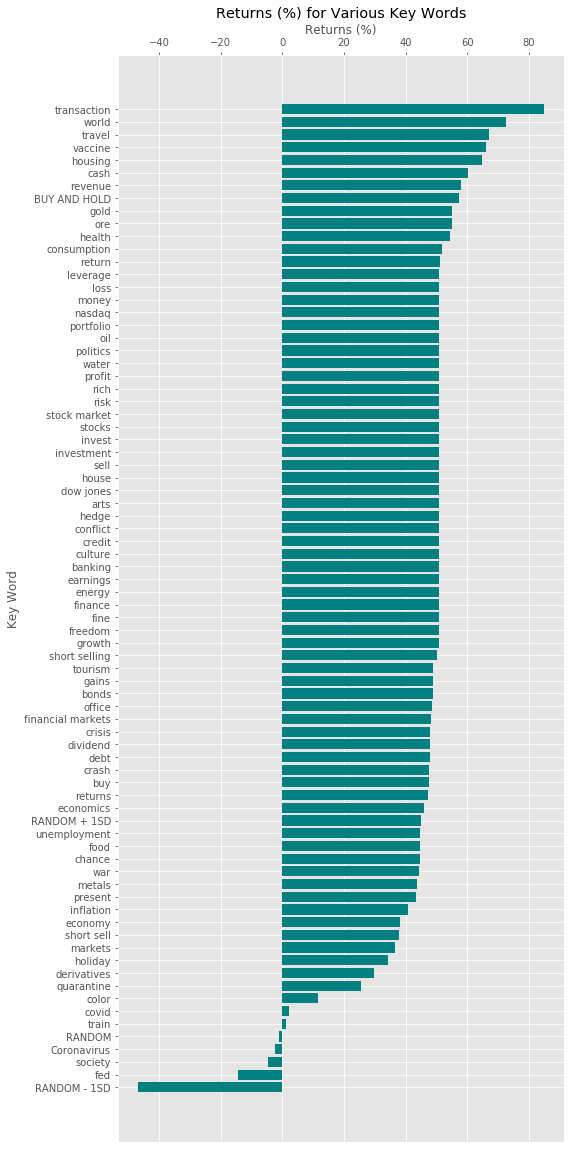

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (8,20))

flipped = random_df.reindex(index = random_df.index[::-1])

plt.style.use('ggplot')
plt.title("Returns (%) for Various Key Words")
plt.ylabel("Key Word")
plt.xlabel("Returns (%)")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.barh(data = flipped, width = "Returns (%)", y = flipped.index, color='teal', align = 'center')

### Graphing Sharpe Ratios of each keyword in testing (2018 - 2020)

<BarContainer object of 74 artists>

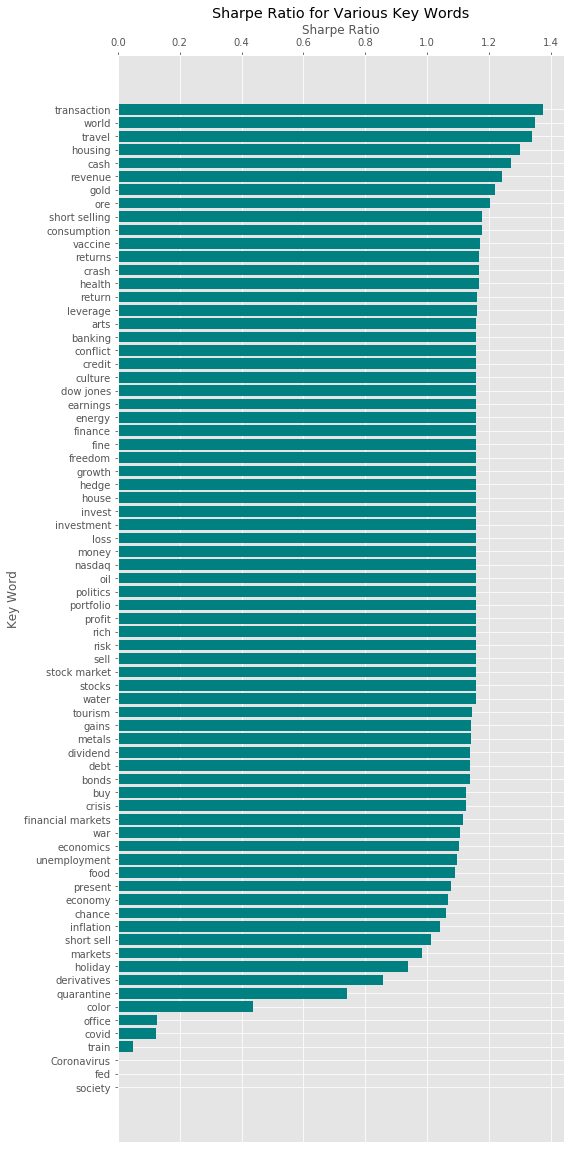

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (8,20))

flipped = testing_sharpe.reindex(index = testing_sharpe.index[::-1])

plt.style.use('ggplot')
plt.title("Sharpe Ratio for Various Key Words")
plt.ylabel("Key Word")
plt.xlabel("Sharpe Ratio")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.barh(data = flipped, width = "Sharpe Ratio", y = flipped.index, color='teal', align = 'center')

### Equity over time of all keywords

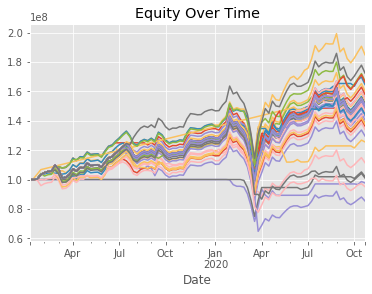

In [54]:
for word in list(training.keys()):
    stat = testing_stats[word]
    stat["_equity_curve"]['Equity'].plot()
x=plt.title('Equity Over Time')

### Equity over time of best performing keywords compared to the random strategy mean $\pm$ 1$\sigma$

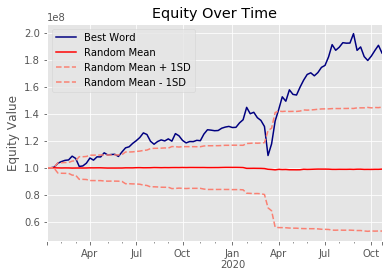

In [55]:
best_stat = testing_stats[best_word]
best = best_stat["_equity_curve"]['Equity'].plot(color='navy', label="Best Word")

mean = random_rolling_mean_and_sd['mean'].plot(color='r', label = 'Random Mean')
mean_plus = (random_rolling_mean_and_sd['mean']+random_rolling_mean_and_sd["sd"]).plot(color='salmon', label = 'Random Mean + 1SD', linestyle='dashed')
mean_minus = (random_rolling_mean_and_sd['mean']-random_rolling_mean_and_sd["sd"]).plot(color='salmon', label = 'Random Mean - 1SD', linestyle='dashed')

plt.ylabel('Equity Value')
plt.legend()
x=plt.title('Equity Over Time')

## Conclusions
From our backtesting, it seems that a strategy using Google Trends alternative data does provide an edge. However, performance is largely dependent on the keywords used. From our list of keywords, 7 outperformed a buy and hold strategy and many had sharpe ratios > `1.0` in the testing data backtest. Almost all keywords outperformed a random buying and selling strategy.

### Future Explorations and Improvements
A problem that could be addressed is obtaining more reliable data quickly, as described in the Data Collection and Processing section. Because there is inherent randomness in both our data pipeline and optimization process, we noticed slight difference in performance between runs. A possible, but time consuming, solution to this would be to take many samples of requests from Google Trends and use a mean.

Due to our limited computing resouces, we could only test about 100 words (specified in words.txt) that were hand-picked. However, there are almost definately search terms that will outperform our current keywords that we did not find. Additionally, some search terms were very correlated with current or past events (i.e. "covid", "coronavirus", "vaccine") that perform well within their respective time periods, but not in others. A more comprehensive test of both finance and non-finance keywords would likeley yield better keyword candidates.